# Face recognition using CNN 

# importing the require libraries 

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from os import listdir
import cv2
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
import numpy as np 
from mtcnn.mtcnn import MTCNN
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from keras.models import load_model
from time import time
import matplotlib.pyplot as plt
from numpy import expand_dims

# Making the function to load the photos and crop them them 

## We use the MTCNN face detector to detect the faces in the images and then crop them and save a new dataset with cropped faces


## The dataset for neural network require many pictures, for the available dataset on the     internet we used subset of the LFW face recognition famous datset 
## The subset we used the top 5 classes each has more than 100 pictures (less than 1000 in total)

<img src="Capture.png" width="800" height="400">


In [21]:
required_size=(160, 160) # the requre size for MTCNN model
directory = "dat/" # the dataset directory 
X, y = list(), list() # training and labels list 

for subdir in listdir(directory):

    path = directory + subdir + '/' # the path of the image
    faces = list() # faces list for all faces in the directory 
    
    for filename in listdir(path):  # loop for all files
        filepath = path + filename #file path

        image = Image.open(filepath)# load the inage from the path
        image = image.convert('RGB') #convert the image to RGB (MTCNN requires RGB images )
        pixels = asarray(image) # the aimage as an array of pixels  
        detector = MTCNN() # face detector 
        results = detector.detect_faces(pixels) # the face 
        x1, y1, width, height = results[0]['box'] # creat the boundering box for the face ([0] is for tge first face in the image)
        x1, y1 = abs(x1), abs(y1) # take the abs of X1 and Y1 so we don't get any negative value anyway
        x2, y2 = x1 + width, y1 + height # boundary box dimension
        face = pixels[y1:y2, x1:x2] # face 
        image = Image.fromarray(face) # get the image from the array 
        image = image.resize(required_size) # resize to 160 * 160
        face_array = asarray(image) # safe the face as array
        faces.append(face_array) # add the face to the faces list 


    # create labels
    labels = [subdir for _ in range(len(faces))]
    # summarize progress
    print('>loaded %d examples for class: %s' % (len(faces), subdir))
    # store
    X.extend(faces)
    y.extend(labels)

>loaded 109 examples for class: Colin_Powell
>loaded 109 examples for class: Donald_Rumsfeld
>loaded 109 examples for class: George_W_Bush
>loaded 109 examples for class: Gerhard_Schroeder
>loaded 109 examples for class: Tony_Blair


# We split the data into 3 parts for training testing and validation

In [22]:

X = np.asarray(X)
y = np.asarray(y)
X.shape, y.shape

((545, 160, 160, 3), (545,))

In [23]:
from sklearn.model_selection import train_test_split

X = np.asarray(X)
y = np.asarray(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Xtest, Xval, ytest, yval = train_test_split(X_test,y_test, test_size=0.3)

# divide the databy 255 to keep the value betwwwn 0 - 1
X_train = X_train.astype('float32')/255
Xtest = Xtest.astype('float32')/255
Xval = Xval.astype('float32')/255

print(Xval.shape, yval.shape)
print(Xtest.shape, ytest.shape)

print(X_train.shape, y_train.shape)


(50, 160, 160, 3) (50,)
(114, 160, 160, 3) (114,)
(381, 160, 160, 3) (381,)


# Encode the label using label encoder 

In [24]:

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
ytest_encoded = label_encoder.fit_transform(ytest)
yval_encoded = label_encoder.fit_transform(yval)

In [25]:
trainY = to_categorical(y_train_encoded)
testY = to_categorical(ytest_encoded)
valY = to_categorical(yval_encoded)
print(trainY.shape)

(381, 5)


# Design the CNN model archetecture 

In [26]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [27]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))


model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.adam(),
              metrics=['accuracy'])

In [28]:
batch_size = 60
num_epoch = 30
#model training
model_log = model.fit(X_train, trainY,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,
          validation_data=(Xval, valY))

Train on 381 samples, validate on 50 samples
Epoch 1/30
381/381 [==============================] - 8s 21ms/step - loss: 1.6432 - accuracy: 0.1864 - val_loss: 1.6023 - val_accuracy: 0.2800
Epoch 2/30
381/381 [==============================] - 6s 16ms/step - loss: 1.6087 - accuracy: 0.2441 - val_loss: 1.6083 - val_accuracy: 0.2200
Epoch 3/30
381/381 [==============================] - 6s 15ms/step - loss: 1.6020 - accuracy: 0.2336 - val_loss: 1.6182 - val_accuracy: 0.1400
Epoch 4/30
381/381 [==============================] - 6s 15ms/step - loss: 1.5949 - accuracy: 0.2598 - val_loss: 1.5792 - val_accuracy: 0.4000
Epoch 5/30
381/381 [==============================] - 6s 17ms/step - loss: 1.5719 - accuracy: 0.3701 - val_loss: 1.5400 - val_accuracy: 0.4600
Epoch 6/30
381/381 [==============================] - 6s 15ms/step - loss: 1.5224 - accuracy: 0.4042 - val_loss: 1.4715 - val_accuracy: 0.3200
Epoch 7/30
381/381 [==============================] - 6s 17ms/step - loss: 1.4474 - accuracy: 0.3

In [29]:
# Model summary 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13084 (Conv2D)        (None, 160, 160, 32)      896       
_________________________________________________________________
max_pooling2d_6544 (MaxPooli (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_13085 (Conv2D)        (None, 53, 53, 64)        18496     
_________________________________________________________________
max_pooling2d_6545 (MaxPooli (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_13086 (Conv2D)        (None, 17, 17, 128)       73856     
_________________________________________________________________
max_pooling2d_6546 (MaxPooli (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 128)        

# Evaluate the model

# Classification report of the testing 

In [30]:

from sklearn.metrics import classification_report
from keras.models import load_model

test_pred = model.predict(Xtest)
test_p_label = np.argmax(test_pred, axis=1)
test_label= np.argmax(testY, axis=1)
print("----------------------------------")
print("report for testing data")

print(classification_report(test_p_label, test_label))


----------------------------------
report for testing data
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        28
           1       0.83      1.00      0.90        19
           2       1.00      0.83      0.91        24
           3       0.76      0.76      0.76        17
           4       0.71      0.77      0.74        26

    accuracy                           0.84       114
   macro avg       0.85      0.84      0.84       114
weighted avg       0.85      0.84      0.84       114



# Plot the accuracy fig

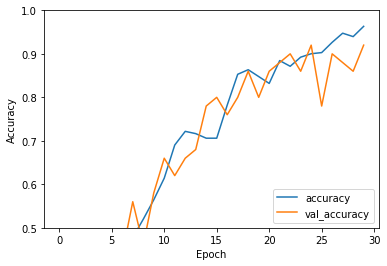

In [31]:
plt.plot(model_log.history['accuracy'], label='accuracy')
plt.plot(model_log.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(Xtest,  testY, verbose=2)

# Plot the validation loss

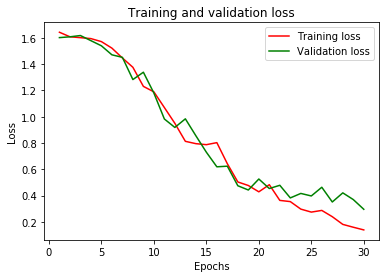

In [32]:
loss = model_log.history['loss']
val_loss = model_log.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy  

In [33]:
print(test_acc)

0.8421052694320679


# Confusion matrix

In [34]:
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn import metrics
import numpy as np 
from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot

In [35]:
score_train = accuracy_score(test_label, test_p_label)
score_test = accuracy_score(test_label, test_p_label)
matrics = confusion_matrix(test_label,test_p_label)


In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_label, test_p_label)

array([[24,  0,  1,  0,  1],
       [ 2, 19,  1,  0,  1],
       [ 0,  0, 20,  0,  0],
       [ 0,  0,  0, 13,  4],
       [ 2,  0,  2,  4, 20]], dtype=int64)

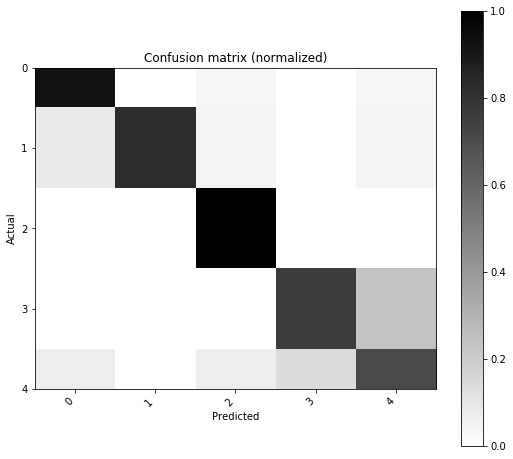

In [37]:
cm = ConfusionMatrix(test_label, test_p_label)

cm.plot(normalized=True)
plt.show()

# Calculate the FP, FN, TP and TN from the Confusion matrix 

In [38]:
FP = matrics.sum(axis=0) - np.diag(matrics)  
FN = matrics.sum(axis=1) - np.diag(matrics)
TP = np.diag(matrics)
TN = matrics.sum() - (FP + FN + TP)
print('FP = ', sum(FP))
print('FN = ',sum(FN))
print('TP = ',sum(TP))
print('TN = ',sum(TN))

FP =  18
FN =  18
TP =  96
TN =  438
